# Classification des images : Lasagnes vs. Hot-Dog (vs. Hamburgers vs. Raviolis)

Dans ce notebook, nous allons nous intéresser à la reconnaissance d'images, en bon anglais : **Computer Vision**

Nous aborderons les éléments suivants : 
* Les réseaux de convolutions (a.k.a. convnets a.k.a. CNN)
* L'augmentation des données 
* La réutilisation et l'adaptation de réseaux existants



## Le MNIST (le Hello World de la classification d'images)

Le MNIST (Mixed National Institute of Standards and Technology) est une base de données contenant 70 000 (60 000 pour l'entrainement et 10 000 pour la validation) chiffres écrits à la main. Avec ce jeu de données, nous pouvons construire des algorithmes permettant de reconnaitre les chiffres.

Un réseau de neurones traditionnel (totalement connecté), comme pour le précédent exercice de classification du vin, fonctionnera dans une certaine mesure. Cependant, les performances (qualité du modèle évaluée avec la précision des résultats) seront bien meilleures avec un réseau de convolution.

### GPU or not GPU?

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

### Construction du réseau

Notre réseau prendra en paramètres des images de chiffres écrits manuellement, ces images ayant pour dimension 28 pixels sur 28, et un seul canal colorimétrique (une image en niveau de gris pour le reformuler clairement)

Création du modèle et ajout des 3 premières couches (Convolution) : 

In [1]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Description du modèle

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


Ajout des couches totalement connectées (Classifier)

In [4]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

### Téléchargement des données

In [6]:
from keras.datasets import mnist
from keras.utils import to_categorical
from matplotlib import pyplot as plt

%matplotlib inline

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

### Affichages des 9 premières images

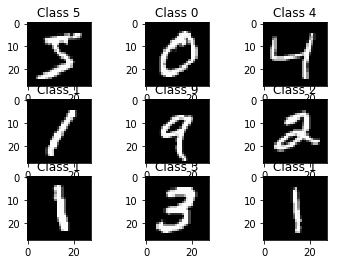

In [7]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(train_labels[i]))

In [8]:
train_images.shape

(60000, 28, 28)

### Préparation et redimensionnement des données d'entrée

Before training, we’ll preprocess the data by reshaping it into the shape the network
expects and scaling it so that all values are in the [0, 1] interval. Previously, our train-
ing images, for instance, were stored in an array of shape (60000, 28, 28) of type
uint8 with values in the [0, 255] interval. We transform it into a float32 array of
shape (60000, 28 * 28) with values between 0 and 1.

In [9]:
train_images = train_images.reshape((60000, 28, 28, 1))

In [10]:
train_images.shape

(60000, 28, 28, 1)

In [11]:
train_images = train_images.astype('float32') / 255

In [12]:
train_images.shape

(60000, 28, 28, 1)

In [13]:
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 15s 250us/step - loss: 0.1777 - acc: 0.9440
Epoch 2/5
60000/60000 [==============================] - 15s 248us/step - loss: 0.0470 - acc: 0.9853
Epoch 3/5
60000/60000 [==============================] - 15s 247us/step - loss: 0.0320 - acc: 0.9902
Epoch 4/5
60000/60000 [==============================] - 15s 247us/step - loss: 0.0246 - acc: 0.9925
Epoch 5/5
60000/60000 [==============================] - 15s 249us/step - loss: 0.0190 - acc: 0.9941


In [14]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 87us/step


[0.029602359310774772, 0.9929]

## Lasagnes vs Hots-Dogs

Classifier des chiffres manuscrits est un passage obligé lorsque l'on débute dans la classification d'images. Mais ce type d'architecture peut être utilisé pour classifiers tout type d'images.

Ici, nous allons classifier des photos de plats, issus du dataset food101 ( https://www.vision.ee.ethz.ch/datasets_extra/food-101/ )

Dans ce dataset nous avons 100 catégories de plats. Chaque catégorie contenant 1000 images.
1000 images c'est à la fois beaucoup (il a fallu récupérer ces photographies, les classifier manuellement, etc.) mais c'est très peu pour un algorithme de reconnaissance d'images qui a besoin de beaucoup plus d'images.

Cette exercice reprend l'article du blog Keras 'Cats vs. Dogs' (https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html). L'article d'origine permet de classifier entre 2 catégories (classification binaire). Notre objectif lors de cet atelier est de classifier parmi 4 catégories.

### Réutilisation d'un réseau existant

Nous pourrions créer notre propre réseau de convolution et l'entrainer avec les 100 000 images du dataset pour calculer les différents paramètres du modèle. Malheureusement, cela serait un peu long (vous pouvez essayer chez vous...).

Une autre approche serait de se baser sur un réseau existant. Keras propose différents réseaux pré-entrainés et prêt à l'emploi ( https://keras.io/applications/ ): 

* VGG16
* VGG19
* ResNet50
* Inception V3
* Xception
* ..

Ces réseaux ont été entrainés sur le dataset ImageNet : 1.4 millions d'images classifiées en 1000 catégories. Outre le fait que ces réseaux fonctionnent déjà très bien pour la reconnaissance d'images, le fait de les avoir entrainés sur un tel volume d'images leur a permis de comprendre de quoi était composé une image : formes, contours, plans, etc.

Lorsque nous réutilisons (en les adaptant) ces réseaux pré-entrainés, nous bénéficions de cette connaissance ce qui induit un gain de temps non-négligeable.






### Import des librairies

In [15]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
from IPython.display import Image, display


model = VGG16(weights='imagenet', include_top=True)

In [16]:
def predict(photo):
    """
        Analyse l'image et recherche les catégories auxquelles elle appartient
    """
    img = image.load_img(photo, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    preds = decode_predictions(features)
    return preds

def display_photo(photo):
    display(Image(filename=photo))
    
def display_and_predict(photo):
    display_photo(photo)
    print("Predictions = " + str(predict(photo)))  

Une lasagne...

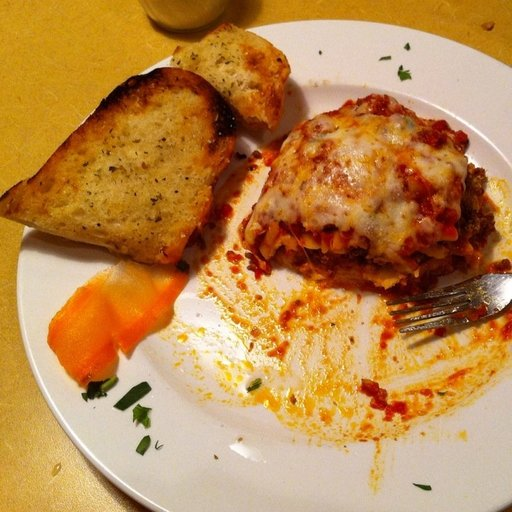

Predictions = [[('n07579787', 'plate', 0.8325696), ('n07871810', 'meat_loaf', 0.025835117), ('n07711569', 'mashed_potato', 0.02034266), ('n07684084', 'French_loaf', 0.014832323), ('n01978287', 'Dungeness_crab', 0.012522868)]]


In [18]:
display_and_predict('./snowcamp/datasets/images/train/lasagna/1089702.jpg')

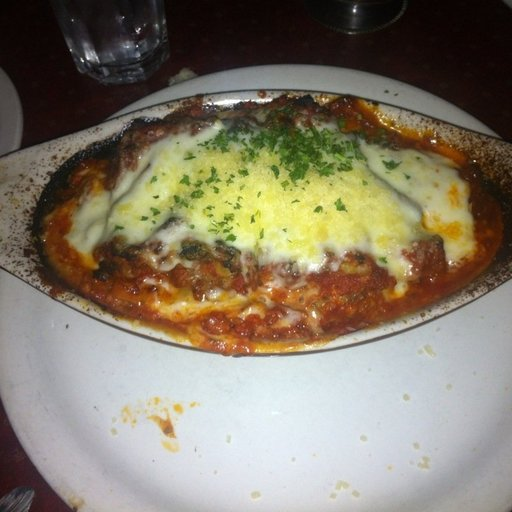

Predictions = [[('n04263257', 'soup_bowl', 0.48267856), ('n07584110', 'consomme', 0.07578548), ('n07590611', 'hot_pot', 0.054676782), ('n07873807', 'pizza', 0.053263754), ('n03400231', 'frying_pan', 0.04972684)]]


In [19]:
display_and_predict('snowcamp/datasets/images/train/lasagna/2009224.jpg')

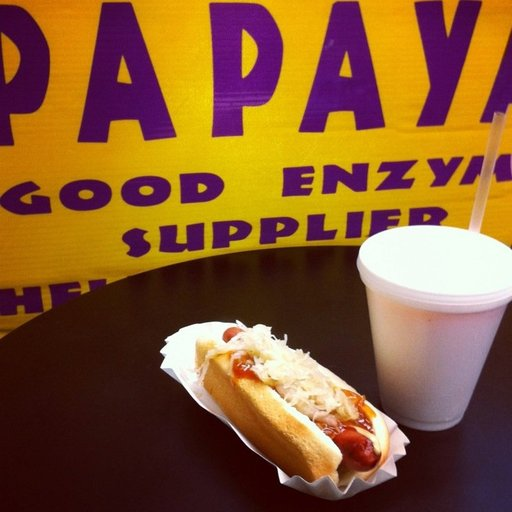

Predictions = [[('n07697537', 'hotdog', 0.6749991), ('n07565083', 'menu', 0.061039884), ('n03871628', 'packet', 0.04606658), ('n07880968', 'burrito', 0.040606223), ('n07875152', 'potpie', 0.018240398)]]


In [20]:
display_and_predict('snowcamp/datasets/images/train/hot_dog/1000288.jpg')

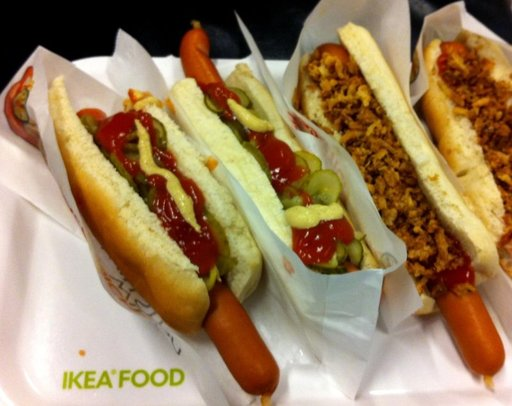

Predictions = [[('n07697537', 'hotdog', 0.99562424), ('n07697313', 'cheeseburger', 0.0039645554), ('n07579787', 'plate', 0.00017103466), ('n07684084', 'French_loaf', 8.441207e-05), ('n02776631', 'bakery', 2.7121087e-05)]]


In [21]:
display_and_predict('snowcamp/datasets/images/train/hot_dog/302949.jpg')

### Constantes

In [22]:
train_data_dir = 'snowcamp/datasets/images/train/'
validation_data_dir = 'snowcamp/datasets/images/validation/'
img_width, img_height = 224,224
nb_categories = 2
batch_size = 50
nb_train_samples = nb_categories * 800
nb_validation_samples = nb_categories * 200

### Data augmentation

Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit. Data augmentation takes the approach of generating more training data
from existing training samples, by augmenting the samples via a number of random
transformations that yield believable-looking images. The goal is that at training time,
your model will never see the exact same picture twice. This helps expose the model
to more aspects of the data and generalize better.
In Keras, this can be done by configuring a number of random transformations to
be performed on the images read by the ImageDataGenerator instance. Let’s get
started with an example

In [23]:
from keras.preprocessing.image import ImageDataGenerator

These are just a few of the options available (for more, see the Keras documentation).
Let’s quickly go over this code:
* rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
* width_shift and height_shift are ranges (as a fraction of total width or
height) within which to randomly translate pictures vertically or horizontally.
* shear_range is for randomly applying shearing transformations.
* zoom_range is for randomly zooming inside pictures.
* horizontal_flip is for randomly flipping half the images horizontally—rele-
vant when there are no assumptions of horizontal asymmetry (for example,
real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can
appear after a rotation or a width/height shift.

In [24]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [25]:
import os 

from keras.preprocessing import image
fnames = [os.path.join(train_data_dir + 'lasagna/', fname) for
fname in os.listdir(train_data_dir + 'lasagna/')]
img_path = fnames[3]

img = image.load_img(img_path, target_size=(150, 150))

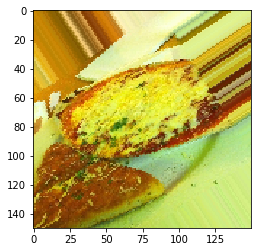

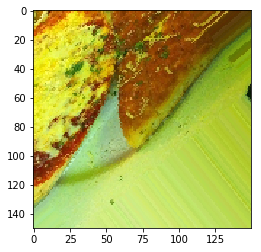

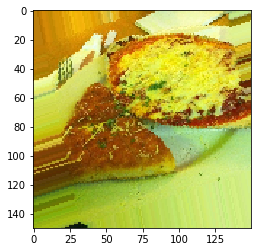

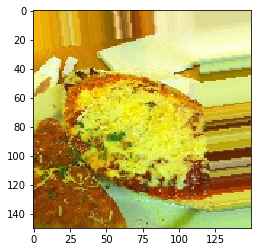

In [26]:
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [28]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

    # build the VGG16 network
    model = VGG16(include_top=False, weights='imagenet')

    print ("Create train matrix...")
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    print ("Bottleneck features are OK...")
    np.save(open('bottleneck_features_train_all_v2.npy', 'wb'), bottleneck_features_train)

    print ("Create validation matrix...")
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation_all_v2.npy', 'wb'),
            bottleneck_features_validation)

In [29]:
save_bottleneck_features()

Create train matrix...
Found 1600 images belonging to 2 classes.
Bottleneck features are OK...
Create validation matrix...
Found 400 images belonging to 2 classes.


In [30]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

epochs=50
top_model_weights_path='bottleneck_fc_model_all_v2.h5'

#Create labels
def create_target_row(nb_categories, cat):
    res = [0] * nb_categories
    res[cat] = 1
    return res

def create_target(rows_by_cat, nb_cat):
    target = []
    for i in range(0,nb_cat):
        for j in range(0, rows_by_cat):
            target.append(create_target_row(nb_cat, i))
    return np.array(target)

def train_top_model():
    train_data = np.load(open('bottleneck_features_train_all_v2.npy', 'rb'))
    # the features were saved in order, so recreating the labels is easy
    train_labels = create_target(800, nb_categories)

    validation_data = np.load(open('bottleneck_features_validation_all_v2.npy', 'rb'))
    validation_labels = create_target(200, nb_categories)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))    
    model.add(Dense(nb_categories, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)

In [31]:
train_top_model()

Train on 1600 samples, validate on 400 samples
Epoch 1/50
1600/1600 [==============================] - 2s 1ms/step - loss: 7.9922 - acc: 0.5012 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/step - loss: 8.0288 - acc: 0.5019 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/step - loss: 8.0389 - acc: 0.5013 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/step - loss: 8.0389 - acc: 0.5012 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/step - loss: 8.0288 - acc: 0.5019 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/step - loss: 8.0288 - acc: 0.5019 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/step - loss: 8.0188 - acc: 0.5025 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 8/50
1600

In [32]:
from keras.layers import Input, Dense
from keras.models import Model

train_data = np.load(open('bottleneck_features_train_all_v2.npy', 'rb'))

input_tensor = Input( shape=(img_width,img_height ,3) )
base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_categories, activation='softmax'))
top_model.load_weights(top_model_weights_path)

loaded_model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

In [34]:
img = image.load_img('./snowcamp/datasets/images/validation/lasagna/3355991.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
features = loaded_model.predict(x)

In [35]:
features

array([[0., 1.]], dtype=float32)

In [36]:
img = image.load_img('./snowcamp/datasets/images/validation/hot_dog/2889560.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
features = loaded_model.predict(x)

In [37]:
features

array([[1., 0.]], dtype=float32)